#### Packages to install
---

`pip install python_speech_features`

`pip install librosa`

## Recreation of Baseline Model
---
Attempting to recreate modeling of baseline with kNN found here:  
* https://data-flair.training/blogs/python-project-music-genre-classification/
* https://www.kaggle.com/code/rxsraghavagrawal/music-genre-classification-using-knn-begineers/notebook

In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np
from tempfile import TemporaryFile
import os
import pickle
import random 
import operator
import math
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
import IPython.display as ipd

In [2]:
def distance(instance1, instance2, k):
    distance = 0
    mm1 = instance1[0]
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    distance += (np.dot(np.dot((mm2-mm1).transpose(),
                               np.linalg.inv(cm2)), mm2-mm1))
    distance += np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance -= k
    return distance

def getNeighbors(trainingSet, trainingClass, instance, k):
    distances = []
    for x in range (len(trainingSet)):
        dist = distance(trainingSet[x], instance, k )+ distance(instance, trainingSet[x], k)
        distances.append((trainingClass[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

# def getAccuracy(testSet, predictions):
#     correct = 0 
#     for x in range (len(testSet)):
#         if testSet[x][-1]==predictions[x]:
#             correct+=1
#     return 1.0*correct/len(testSet)

def nearestClass(neighbors):
    classVote = {}
    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response]+=1 
        else:
            classVote[response]=1
    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)
    return sorter[0][0]

`scipy.io.wavfile.read` enables you to read a `.WAV` file as array and also outputs the sample rate of the file. Sample rate is the number of samples of audio carried per second (Hz)

### Read in data and store MFCC features as binary .dat file.

In [3]:
%%time
directory = "../data/"
f= open("my.dat" ,'wb')
# i=0
for folder in os.listdir(directory):
    if folder=="mf_files":
        continue
#     i+=1
#     if i==11 :
#         break   
    for file in os.listdir(directory+folder):  
        (rate,sig) = wav.read(directory+folder+"/"+file)
        mfcc_feat = mfcc(sig,rate ,winlen=0.020, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix , covariance , folder)
        pickle.dump(feature , f)
f.close()

CPU times: user 4min 26s, sys: 17.9 s, total: 4min 44s
Wall time: 1min 17s


In [13]:
blue_sig1, blue_sr1 = librosa.load("../data/blues/blues.00099.wav",sr=None)
n_mfcc = 13
n_mels = 40
n_fft = 512 
hop_length = 160
librosa.feature.mfcc(y= blue_sig1,sr = blue_sr1)

array([[-279.49826   , -252.23665   , -254.31746   , ..., -241.90556   ,
        -253.60144   , -253.82927   ],
       [ 117.39602   ,  122.0423    ,  123.86777   , ...,  158.97546   ,
         162.62677   ,  159.35457   ],
       [  20.377195  ,   15.743496  ,    5.5872507 , ...,  -21.799938  ,
         -14.356788  ,    1.4669918 ],
       ...,
       [  -0.8632754 ,   -4.3398924 ,   -7.8607574 , ...,   -6.414109  ,
          -6.388008  ,   -4.340525  ],
       [   0.68263245,   -3.2156677 ,   -8.483074  , ...,  -24.163555  ,
         -19.558498  ,  -18.133522  ],
       [  -4.0142055 ,   -6.553997  ,  -13.854462  , ...,  -22.345444  ,
         -21.309814  ,  -15.943977  ]], dtype=float32)

In [12]:
mfcc(blue_sig1,blue_sr1 ,winlen=0.020, appendEnergy = False)

array([[-44.10256911,  -3.9247684 ,  -1.53327968, ..., -26.66752438,
        -12.33839932, -28.68744731],
       [-44.84303179,  -3.81903483,  -1.81799789, ..., -29.38857689,
        -12.65214644, -26.24478408],
       [-44.88194051,  -1.2901342 ,   0.17079873, ..., -21.14195759,
         -9.02464937, -27.52466498],
       ...,
       [-44.76212302,  12.82598822, -12.5673351 , ...,  -5.37034119,
         11.97615207, -13.68131927],
       [-45.06957474,  12.623213  , -13.03990441, ...,  -0.30508616,
         13.1768068 , -17.43520376],
       [-46.44828301,  11.37208936, -13.49911924, ...,   6.71100845,
         19.31932068, -15.98848471]])

In [14]:
# %%time
# directory = "../data/"
# f= open("my.dat" ,'wb')
# # i=0
# for folder in os.listdir(directory):
#     if folder=="mf_files":
#         continue
# #     i+=1
# #     if i==11 :
# #         break   
#     for file in os.listdir(directory+folder):  
#         (rate,sig) = wav.read(directory+folder+"/"+file)
#         mfcc_feat = mfcc(sig,rate ,winlen=0.020, appendEnergy = False)
#         covariance = np.cov(np.matrix.transpose(mfcc_feat))
#         mean_matrix = mfcc_feat.mean(0)
#         feature = (mean_matrix , covariance , folder)
#         pickle.dump(feature , f)
# f.close()

### Train-Test Split

In [15]:
%%time
dataset = []
def loadDataset(filename):
    with open("my.dat" , 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break 
    df = np.array(dataset, dtype= object)
    return df
df = loadDataset("my.dat")

CPU times: user 48.9 ms, sys: 1.99 ms, total: 50.9 ms
Wall time: 50.2 ms


In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(df[:,0:2], 
                                                df[:,2],
                                                test_size = 0.25, 
                                                random_state=29,
                                                stratify = df[:,2])

In [24]:
trainY[0]

'disco'

In [35]:
%%time
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(estimator=get)
from sklearn.metrics import accuracy_score
## Do custom GridSearch using repeated 5-fold CV

from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats=3)
k_vals = np.arange(4,30,2)
# k_vals = [5,10]
k_scores = []
for k in k_vals:
    accuracies = []
    print("K:",k)
    for trainInd, testInd in rskf.split(trainY, trainY):
        train_x, test_x = trainX[trainInd], trainX[testInd]
        train_y, test_y = trainY[trainInd], trainY[testInd]
        
        length = len(test_x)
        predictions = []
        for x in range(length):
            predictions.append(nearestClass(getNeighbors(train_x, train_y, test_x[x], k)))
        accuracy1 = accuracy_score(test_y, predictions)
        accuracies.append(accuracy1)
    k_scores.append(np.mean(accuracies))

K: 4
K: 6
K: 8
K: 10
K: 12
K: 14
K: 16
K: 18
K: 20
K: 22
K: 24
K: 26
K: 28
CPU times: user 28min 57s, sys: 91.6 ms, total: 28min 57s
Wall time: 28min 57s


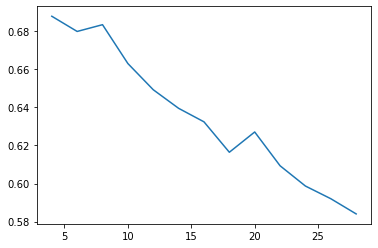

In [36]:
plt.plot(k_vals, k_scores)

In [37]:
%%time
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(estimator=get)
from sklearn.metrics import accuracy_score
## Do custom GridSearch using repeated 5-fold CV

from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats=3)
k_vals = np.arange(4,10,1)
# k_vals = [5,10]
k_scores = []
for k in k_vals:
    accuracies = []
    print("K:",k)
    for trainInd, testInd in rskf.split(trainY, trainY):
        train_x, test_x = trainX[trainInd], trainX[testInd]
        train_y, test_y = trainY[trainInd], trainY[testInd]
        
        length = len(test_x)
        predictions = []
        for x in range(length):
            predictions.append(nearestClass(getNeighbors(train_x, train_y, test_x[x], k)))
        accuracy1 = accuracy_score(test_y, predictions)
        accuracies.append(accuracy1)
    k_scores.append(np.mean(accuracies))

K: 4
K: 5
K: 6
K: 7
K: 8
K: 9
CPU times: user 13min 26s, sys: 52.8 ms, total: 13min 26s
Wall time: 13min 26s


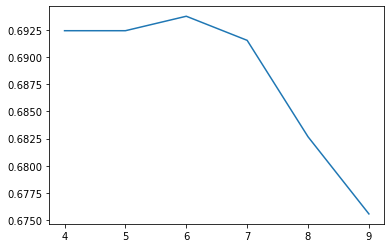

In [38]:
plt.plot(k_vals, k_scores)

In [43]:
predictions = []
for x in range(len(testX)):
    predictions.append(nearestClass(getNeighbors(trainX, trainY, testX[x], 6)))
print(accuracy_score(testY, predictions))

0.664


In [42]:
len(predictions)

150

#####  Reading in Files
---
Blues is a mono channel

In [8]:
ipd.Audio("../data/blues/blues.00041.wav")

#### References
* https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
* https://www.analyticsvidhya.com/blog/2021/06/visualizing-sounds-librosa/

